In [2]:
import os
import pandas as pd
import pathlib

curr_path = os.path.abspath('..')
folder_path = os.path.join(curr_path, 'Datasets/')
data_path = os.path.join(folder_path, 'OneStopEnglish/Texts-SeparatedByReadingLevel')
stopwords_path = os.path.join(curr_path, 'DataExploration','newsela_stopwords.txt')
with open(stopwords_path, 'r') as f:
    stopwords = f.read().split()

# OneStopEnglish Dataset Readability Baselines

Flesch-Kincaid Grade Level: Scores text at a U.S grade level.  Uses word counts, sentence counts and syllable counts.
When the number is great than 10, is the number of years required to understand the text.  Expectation: Harder the text, larger the number.  No upper bound, lowerbound -3.4 per Wikipedia.  

Flesch Reading Ease: Scale between 1 to 100 on readability (translates directly to predefined schol levels).  Higher the number, easier the text to read.  The lower the number, the more difficult.  Expectation:Harder the text, lower the number.  Upper Bound: 121.22, No theoretical lower bound.

Automated Readability Index (ARI): Uses. characters per word, word counts, sentence counts, lower bound 1 (?), no upper bound

In [3]:
import glob
import numpy as np
from textstat import flesch_reading_ease, flesch_kincaid_grade, automated_readability_index
import re

f_grade = []
f_ease = []
ari = []
avg_tokenlength = []
documentlength_token = []
documentlength_sentence = []
avg_sentencelength_char = []
avg_sentencelength_token = []

text_lvl = []

lvl = ['Adv-Txt', 'Int-Txt', 'Ele-Txt']

ele_txt = []
int_txt = []
adv_txt = []
filename = []
for l in lvl:
    text_path = os.path.join(data_path, l, "*.txt")
    for fname in glob.glob(text_path):
        with open(fname, 'r') as f:
            text = f.read()
        if l == 'Ele-Txt':
            ele_txt.append(text)
        elif l == 'Int-Txt':
            int_txt.append(text)
        else:
            adv_txt.append(text)
        
        tokens = [w for w in re.split('\.|\\n|\s', text) if w != '']
        sentences = [s for s in re.split('\.|\\n', text) if s!= '']
        filename.append(fname.split('/')[-1])
        
        f_grade.append(flesch_kincaid_grade(text))
        f_ease.append(flesch_reading_ease(text))
        ari.append(automated_readability_index(text))
        documentlength_token.append(len(tokens))
        documentlength_sentence.append(len(sentences))
        avg_tokenlength.append(np.mean([len(t) for t in tokens]))
        avg_sentencelength_char.append(np.mean([len(s) for s in sentences]))
        avg_sentencelength_token.append(np.mean([len(s.split()) for s in sentences]))
        text_lvl.append(l)
        
os_english = {'filename':filename,'text_lvl': text_lvl, 'f_grade': f_grade, 'f_ease': f_ease,
              'ari':ari,'avg_tokenlength':avg_tokenlength, 'documentlength_token':documentlength_token,
              'documentlength_sentence':documentlength_sentence,'avg_tokenlength':avg_tokenlength,
              'avg_sentencelength_char':avg_sentencelength_char, 'avg_sentencelength_token': avg_sentencelength_token}

os_english = pd.DataFrame(os_english)
os_english['slug'] = os_english['filename'].str.replace(r'-\w*.txt', '', regex=True)

Text(0.5, 1.0, 'Document Distribution Over Reading Level')

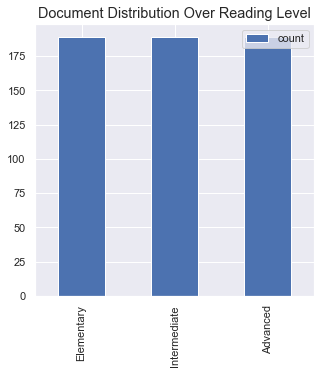

In [205]:
document_dists = {"Elementary":len(ele_txt), "Intermediate":len(int_txt), "Advanced":len(adv_txt)}
document_dists = pd.DataFrame([len(ele_txt), len(int_txt), len(adv_txt)], columns=['count'], index=['Elementary', 'Intermediate', 'Advanced'])
axs = document_dists.plot.bar(y='count', use_index=True, figsize=(5,5))
axs.set_title("Document Distribution Over Reading Level", fontsize="large")

## Heuristic Score Statistics and Visualizations

In [206]:
metric_stats = os_english.groupby('text_lvl')[['f_grade', 'f_ease', 'ari']].agg(['min', 'max', 'mean','std'])
metric_stats = metric_stats.reindex(lvl)

In [207]:
metric_stats

f_grade                            f_ease                    \
             min   max       mean       std    min    max       mean   
text_lvl                                                               
Ele-Txt      5.7  38.2  12.176190  4.664444  -8.55  86.03  59.524233   
Int-Txt      4.9  13.9   9.278307  1.653624  39.16  83.46  64.334180   
Adv-Txt      7.4  44.0  19.863492  6.757698 -28.98  76.96  35.236296   

                     ari                             
                std  min   max       mean       std  
text_lvl                                             
Ele-Txt   14.371893  5.6  48.4  15.422751  5.894296  
Int-Txt    8.217416  6.2  17.2  11.451323  2.021970  
Adv-Txt   19.597324  8.8  55.8  25.031217  8.644106

Text(0.5, 0.98, 'Statistical Measures for Various Readability Assessment Metrics')

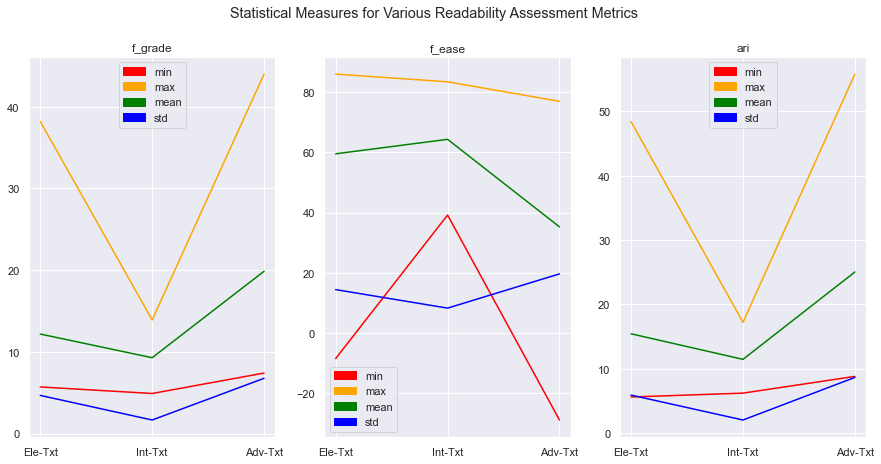

In [208]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['f_grade', 'f_ease', 'ari']

fig, axs = plt.subplots(1,3, figsize=(15, 7))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = metric_stats[s]
    score_stats = score_stats.reindex(lvl)
    patches = []
    
    for i in range(len(colors)):   
        axs[y_counter].plot(score_stats.index, score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[y_counter].legend(handles=patches)
    axs[y_counter].set_title(s)
    
    if y_counter == 2:
        y_counter = 0
        x_counter = 1
    else:
        y_counter += 1

fig.suptitle('Statistical Measures for Various Readability Assessment Metrics')

## N-Gram and Document Lengths

In [209]:
length_stats = os_english.groupby('text_lvl')[['documentlength_token',
                                               'documentlength_sentence',
                                               'avg_tokenlength', 
                                               'avg_sentencelength_char',
                                               'avg_sentencelength_token']].agg(['min', 'max', 'mean','std'])
length_stats = length_stats.reindex(lvl)

Text(0.5, 0.98, 'Statistical Measures for Length Metrics')

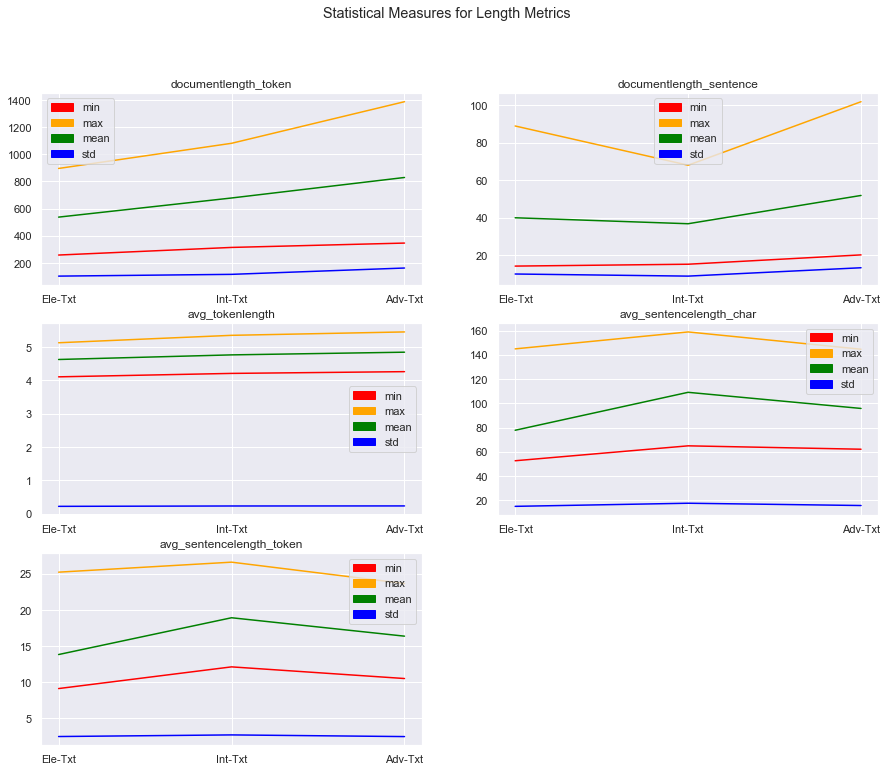

In [210]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['documentlength_token','documentlength_sentence','avg_tokenlength', 'avg_sentencelength_char', 'avg_sentencelength_token']

fig, axs = plt.subplots(3,2, figsize=(15, 12))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = length_stats[s]
    score_stats.reset_index(inplace=True)
    patches = []
    
    for i in range(len(colors)):   
        axs[x_counter, y_counter].plot(score_stats['text_lvl'], score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[x_counter, y_counter].legend(handles=patches)
    axs[x_counter, y_counter].set_title(s)
    
    if y_counter == 1:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1
fig.delaxes(axs[2,1])
fig.suptitle('Statistical Measures for Length Metrics')

## N-Gram Analysis

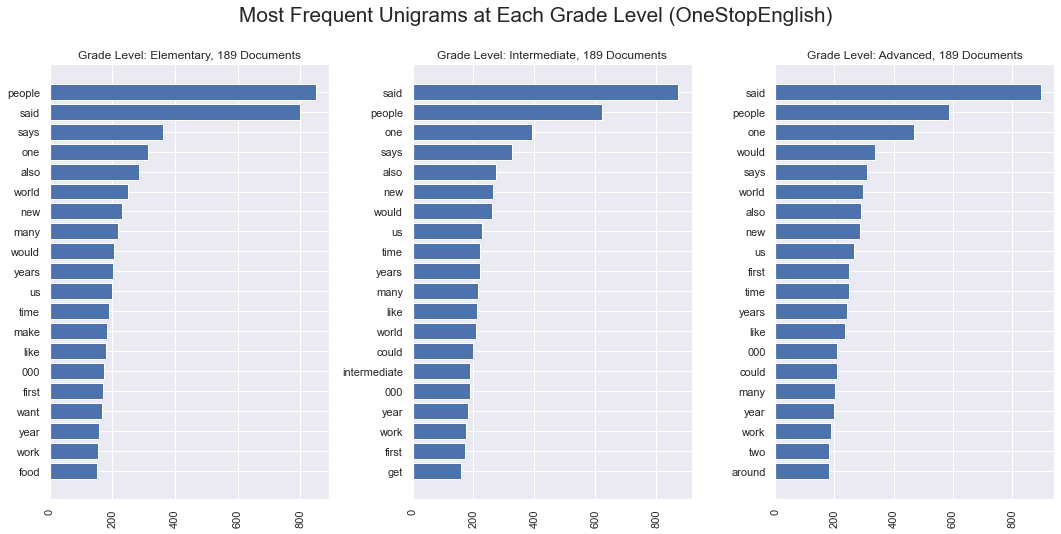

In [211]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(1,3, figsize=(18, 8))
x_counter = 0
y_counter = 0

levels = {"Elementary":ele_txt, "Intermediate":int_txt, "Advanced":adv_txt}

for lvl,txt in levels.items():
    vectorizer = CountVectorizer(stop_words=stopwords)
    counts = np.asarray(np.sum(vectorizer.fit_transform(txt), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[y_counter].barh(keys[::-1], vals[::-1])
    axs[y_counter].tick_params(axis='x', rotation=90)
    axs[y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, len(txt)))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Unigrams at Each Grade Level (OneStopEnglish)',fontsize='xx-large')
plt.savefig('freq_1gram_osenglish.png')

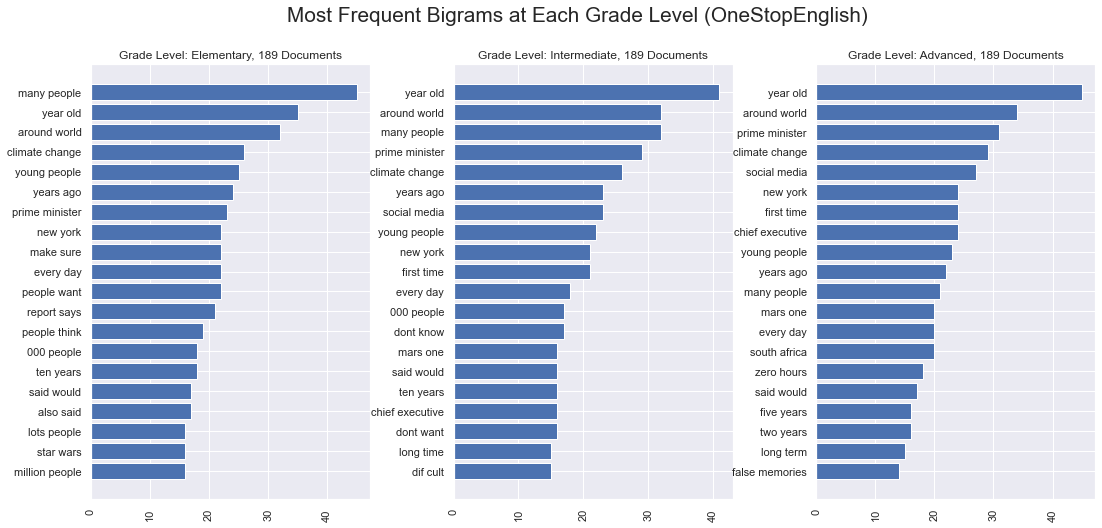

In [212]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(1,3, figsize=(18, 8))
x_counter = 0
y_counter = 0

levels = {"Elementary":ele_txt, "Intermediate":int_txt, "Advanced":adv_txt}

for lvl,txt in levels.items():
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(2,2))
    counts = np.asarray(np.sum(vectorizer.fit_transform(txt), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[y_counter].barh(keys[::-1], vals[::-1])
    axs[y_counter].tick_params(axis='x', rotation=90)
    axs[y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, len(txt)))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Bigrams at Each Grade Level (OneStopEnglish)',fontsize='xx-large')
plt.savefig('freq_2gram_osenglish.png')

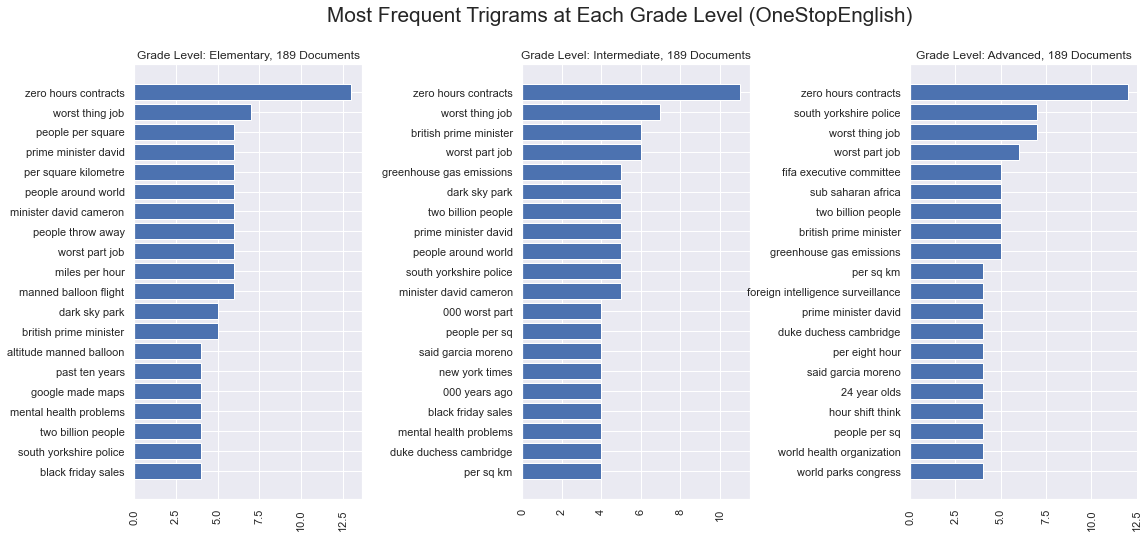

In [213]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(1,3, figsize=(18, 8))
x_counter = 0
y_counter = 0

levels = {"Elementary":ele_txt, "Intermediate":int_txt, "Advanced":adv_txt}

for lvl,txt in levels.items():
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(3,3))
    counts = np.asarray(np.sum(vectorizer.fit_transform(txt), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[y_counter].barh(keys[::-1], vals[::-1])
    axs[y_counter].tick_params(axis='x', rotation=90)
    axs[y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, len(txt)))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.7)
fig.suptitle('Most Frequent Trigrams at Each Grade Level (OneStopEnglish)',fontsize='xx-large')
plt.savefig('freq_3gram_osenglisha.png')

In [4]:
output_path = os.path.join(folder_path, 'os_english_metadata_with_scores.csv')
os_english.to_csv(output_path, index=False)